In [1]:
# Basic imports for libraries and the mnist data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

tf.set_random_seed(0)

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 10)


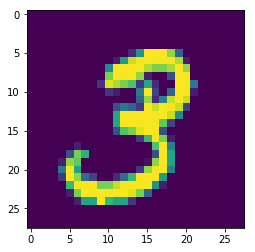

y = [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [2]:
# Visualize the original data
index = 1
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

plt.imshow(mnist.train.images[index, :].reshape(28, 28))
plt.show()
print ("y = " + str(mnist.train.labels[index, :]))

In [3]:
input_dimension = 784
output_dimension = 10

In [4]:
def build_network(x):
    """Build the MNIST model with 2 hidden layers and one linear layer.
    params: 
        x: input placeholder
    Returns: 
        Output tensor with the computed logits
    """
    # define number of neurons per layer
    l1_units = 30
    l2_units = 15
    l3_units = 10
    
    # Hidden 1
    with tf.variable_scope("layer2"):
        w1 = tf.get_variable("w1",[input_dimension, l1_units], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b1 = tf.Variable(tf.zeros([l1_units]), name="b1")
        z1 = tf.matmul(x, w1) + b1
        y1 = tf.nn.relu(z1)
    
    # Hidden 2
    with tf.variable_scope("layer2"):
        w2 = tf.get_variable("w",[l1_units, l2_units], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b2 = tf.Variable(tf.zeros([l2_units]), name="b2")
        z2 = tf.matmul(y1, w2) + b2
        y2 = tf.nn.relu(z2)
   
    # softmax
    with tf.variable_scope("layer3"):
        w3 = tf.get_variable("w3",[l2_units, l3_units], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b3 = tf.Variable(tf.zeros([l3_units]), name="b3")
        z3 = tf.matmul(y2, w3) + b3
        y_ = tf.nn.softmax(z3)
  
    return z3, y_ # logits and probilities


In [5]:
def calc_loss(z3, y):
    """Calculates the loss from the logits and the labels.
    params:
        z3: logits for output tensor from build_network
        y: labeled data indicating the numeric value of the picture, [None, 10]
    """
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=z3, labels=y)
    cross_entropy = tf.reduce_mean(cross_entropy)
    return cross_entropy

In [6]:
def training(loss, learning_rate):
    """Sets up the training Ops.
    params:
        loss: cross entropy loss
        learning_rate
    """
    beta1=0.9
    beta2=0.999
    epsilon=1e-08
    
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    train_op = optimizer.minimize(loss)
    return train_op

In [7]:
def evaluation(y, y_):
    """Evaluate the quality of the logits at predicting the label.
    Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
    """
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [8]:
# Defining placeholders and compile tensors

x = tf.placeholder(tf.float32, [None, input_dimension], name="input")
y = tf.placeholder(tf.float32, [None, output_dimension], name="labels")
z3, y_ = build_network(x)
loss = calc_loss(z3, y)
accuracy = evaluation(y, y_)
train_op = training(loss, learning_rate=0.01)

In [9]:
# Preparing for mini-batching training data
def generate_shuffled_train_data():
    """ Shuffle the images and labels in the training set in unison
    Return:
        shuffled train images and train labels
    """
    assert len(mnist.train.images) == len(mnist.train.labels)
    p = np.random.permutation(len(mnist.train.labels))
    shuffled_train_images = mnist.train.images[p]
    shuffled_train_labels = mnist.train.labels[p]
    return shuffled_train_images, shuffled_train_labels

In [13]:
def generate_mini_batches(batch_size, train_images, train_labels):
    """ Yield mini batches in tuples from the original dataset with a specified batch size
    Params: 
        batch_size: number of training data in a sample
        train_images: all of train images [None, 784] after shuffling
        train_labels: all of train labels [None, 10] after shuffling
    Return:
        A generator yielding each mini batch([batch_num, 784], [batch_num, 10])
    Notes:
        the last data not divisible by mini-batch is thrown away
    """
    train_image_num = len(train_labels)
    for i in range(int(train_image_num / batch_size)):
        start_slice_index = i * batch_size
        end_slice_index = (i + 1) * batch_size
        yield (train_images[start_slice_index:end_slice_index],
               train_labels[start_slice_index:end_slice_index])
    

In [14]:
# Train MNIST classifer and evaluate the accuracy
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Original accuracy:")
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    
    # batch_size_options = [300, 900, 3000, 9000]
    batch_size = 3000
    for epoch in range(100):
        shuffled_train_images, shuffled_train_labels = generate_shuffled_train_data()
        for (batch_train_images, batch_train_labels) in \
            generate_mini_batches(batch_size, shuffled_train_images, shuffled_train_labels):
            sess.run(train_op, feed_dict={x: batch_train_images, y: batch_train_labels})
            
    print("After train accuracy:")
    print(sess.run(accuracy, feed_dict={x: mnist.train.images, y: mnist.train.labels}))
    print("After test accuracy:")
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Original accuracy:
0.0882
After train accuracy:
0.999727
After test accuracy:
0.9598
